In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
import pandas as pd
import copy
from HINTS import *
from HINTS_fn_Student_t import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

# Student t distribution

- overview https://en.wikipedia.org/wiki/Student%27s_t-distribution
- in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html 

A 'non-standard' or 'location-scale' t distribution has the following params:

- &nu; (int >=1) degrees of freedom
- &mu; mean & mode
- &tau; scale parameter



1.0001662486643015  should approx. equal  1.0
1.1618844357359988  should approx. equal  1.1547005383792515


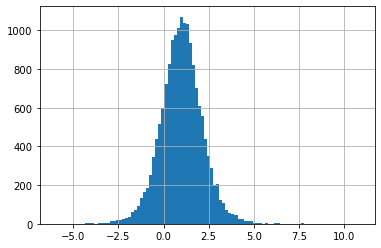

In [3]:
# generate some example data in numpy
mu = 1.0
tau = 1.0 # not the same as sigma because the standard t has variance nu/(nu-2), if this exists
nu = 8 # NB if wer choose low values of nu (dof) we get a very tight distribution
log2N = 14 # size of dataset
NX = 2 ** log2N


eg = mu + np.random.standard_t(nu, size = NX) * tau

print(np.mean(eg), " should approx. equal ", mu)
print(np.std(eg), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts, bins = np.histogram(eg, bins = 100)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.grid() # NB if we make nu smaller we get much fatter tails

0.9918377249339972  should approx. equal  1.0
1.1619439895734593  should approx. equal  1.1547005383792515


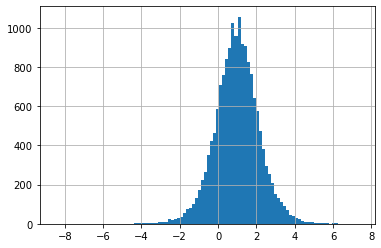

In [4]:
# scipy

np.random.seed(seed=4) # depending on seed, the max likelihood nu may or may not be the same as the nu we used

from scipy.stats import t # non central t

eg2 = t.rvs(nu, loc = mu, scale = tau, size = NX)

print(np.mean(eg2), " should approx. equal ", mu)
print(np.std(eg2), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts2, bins2 = np.histogram(eg2, bins = 100)
_ = plt.hist(bins2[:-1], bins2, weights=counts2)
plt.grid() # NB if we make nu smaller we get much fatter tails

# all looks fine

In [5]:
# log likelihood example (it's not very sensitive to dof!)
print(nu)
mll = t(nu, loc = mu, scale = tau).logpdf(eg2).sum() # likelihood for actual params
print(mll) # actual
print("Neighbours - MLL: will usually be negative (less likely) ") 
print(t(nu-1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu+1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu - 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu + 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau * 1.05).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau / 1.05).logpdf(eg2).sum() - mll)

# NB if we see -10, then it is exp(-10) less likely. So even with N = 10000, the posterior on DOF is very tight 

8
-25489.196478797254
Neighbours - MLL: will usually be negative (less likely) 
-3.7150665039007436
-5.470751554828894
-12.228713015985704
-21.14222245550627
-17.818551739175746
-39.46836741266452


In [76]:

# say we have NX = 2**14 datapoints: arrange as 1024 scenarios each with 16, or 256 by 64
# HINTS will have biggest advantage for small leaf size (mixing time in terms of leaf evals)

LEAF_SIZE = 64 ## vectorise at leaves for speed
NUM_SCENARIOS = NX//LEAF_SIZE
print(NUM_SCENARIOS, "scenarios by", LEAF_SIZE, "in each leaf =", NX, "(dataset size)")

#data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
#print(data.shape)


import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults




if True: # put True in for HINTS, False for simple MCMC where evaluations use all data
    args.levels = 4 #4
    log_branch_factor = 2
    N_0 = 1 # 4 batches of 64 at leaf 
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    args.iterations = 1000
    args.expt = 'HINTS_downsample' #'HINTS100'
    args.proposal_sigma = 0.01/2
    args.skip_after_accept = False
    args.downsample = 2 # do not visit each scenario each time .. NB could be more systematic (with visiting every scenario) but that may not help
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 256
    args.design = np.array([NUM_SCENARIOS])
    args.iterations = 1000 # NB this is not comparable with HINTS iterations ... check the g.counter for actual leaf node (scenario) function evaluations
    args.expt = 'MCMC1000' #'MCMC500'
    args.proposal_sigma = 0.01
    args.skip_after_accept = False

print(NUM_SCENARIOS)

# design now has levels + 1 entries
args.additive = True # natural for lok likelihoods in Bayesian inference
args.T = 1.0 #top level
args.dT = 0.0

print(args.__dict__)

256 scenarios by 64 in each leaf = 16384 (dataset size)
256
{'levels': 4, 'design': array([1, 4, 4, 4, 4]), 'iterations': 1000, 'expt': 'HINTS_downsample', 'proposal_sigma': 0.005, 'skip_after_accept': False, 'downsample': 2, 'additive': True, 'T': 1.0, 'dT': 0.0}


In [77]:
from parallel_funcs_t import run_t_sampler
args.id = 0
args.LEAF_SIZE = LEAF_SIZE
args.NUM_SCENARIOS = NUM_SCENARIOS
args.mu = mu
args.tau = tau
args.nu = nu

#run_t_sampler(args)

In [78]:
# parallel runs : everything goes in args

PARALLEL = 32 # replace with 100 after testing (I only have 4 cpus so I use this for testing)

# for a quick test run with fewer iterations
#args.iterations = 10

#pip install parallelbar
from parallelbar import progress_map

tasks = []
for i in range(PARALLEL): 
    args.id = i
    tasks.append(copy.deepcopy(args))   

ok, failures = progress_map(run_t_sampler, tasks, process_timeout = 14400, error_behavior='coerce', return_failed_tasks=True)

# you can watch progress on the command line output too

print(len(ok), "successes")
print(len(failures), "failures")
if len(failures) >0:
    print(failures)
# check the first result dataframe
print(ok[0].info())

DONE:   0%|          | 0/32 [00:00<?, ?it/s]

32 successes
0 failures
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nu           1001 non-null   int32  
 1   mu           1001 non-null   float64
 2   tau          1001 non-null   float64
 3   acceptances  1001 non-null   object 
 4   rejections   1001 non-null   object 
 5   evals_cache  1001 non-null   int64  
 6   evaluations  1001 non-null   int64  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 51.0+ KB
None


In [79]:
import pickle
fname = args.expt + "_" + str(PARALLEL) + ".pkl"
print("Saving", fname)
pickle.dump(ok, open(fname, "wb" )) # was 100.pkl for main runs with e1, e2

Saving HINTS_downsample_32.pkl


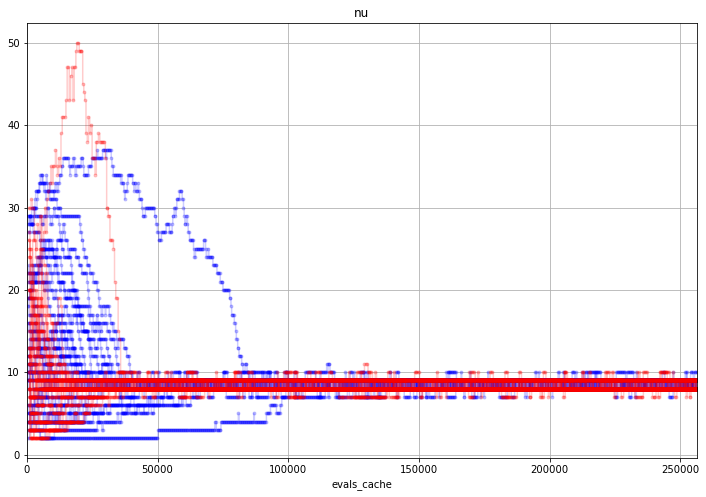

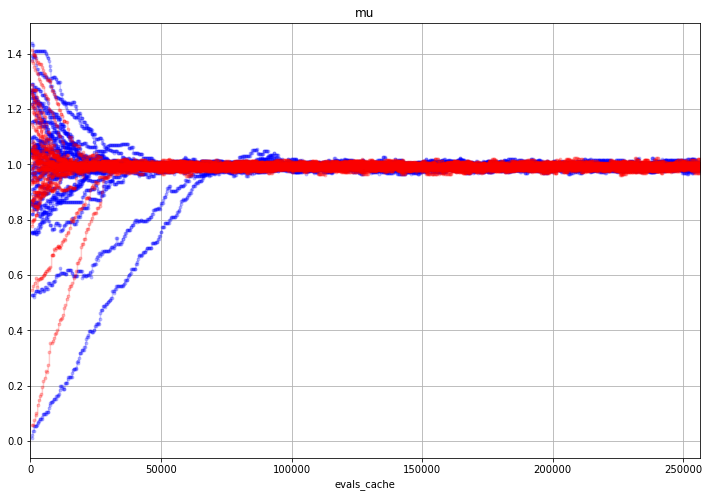

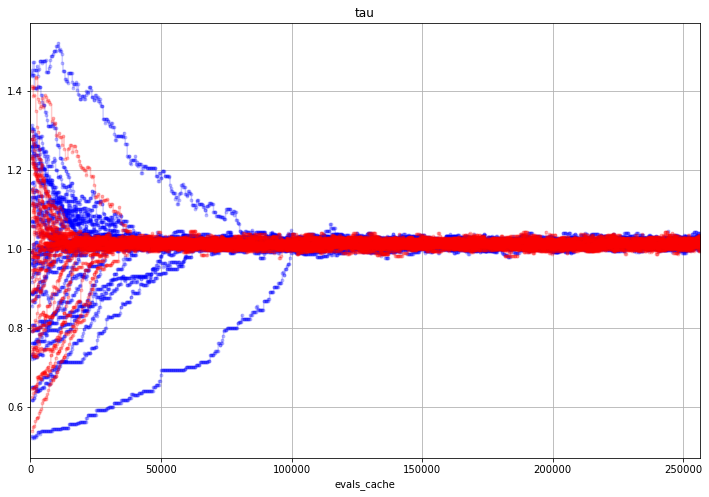

In [81]:
# reload 
res_HINTS = pickle.load(open("HINTS_downsample_32.pkl", "rb"))
res_MCMC = pickle.load(open("MCMC1000_32.pkl", "rb"))

post_bi = False # post burn in
start = 150000 if post_bi else 0

for sx in ['nu', 'mu', 'tau']:
    plt.figure(figsize = [12, 8])
    for run, df in enumerate(res_MCMC):
        df[df.evals_cache > start].set_index('evals_cache')[sx].plot(color = 'blue', alpha = 0.2, marker = '.', drawstyle = 'steps-post')
    for run, df in enumerate(res_HINTS):
        df[df.evals_cache > start].set_index('evals_cache')[sx].plot(color = 'red', alpha = 0.2, marker = '.', drawstyle = 'steps-post')
    plt.grid()
    plt.title(sx)
    plt.xlim(start, res_MCMC[-1].evals_cache.iloc[-1])

# TO DO: test skip after accept
    

In [ ]:
# increase proposal sigma

C:\Users\mjstr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


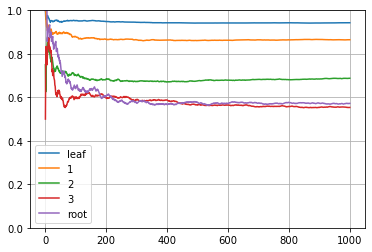

In [82]:
df_HINTS = res_HINTS[0]
A = np.array([np.array(a) for a in df_HINTS['acceptances']])
R = np.array([np.array(r) for r in df_HINTS['rejections']])
plt.plot(A/(A+R))
plt.ylim(0.0, 1.0)
plt.grid()
plt.legend(labels = ['leaf', '1', '2', '3', 'root'])
#df_MCMC = pd.DataFrame(history)

In [12]:
args

Namespace(LEAF_SIZE=64, NUM_SCENARIOS=256, T=1.0, additive=True, dT=0.0, design=array([4, 4, 4, 4]), id=3, iterations=100, levels=3, mu=1.0, nu=8, proposal_sigma=0.0025, tau=1.0)

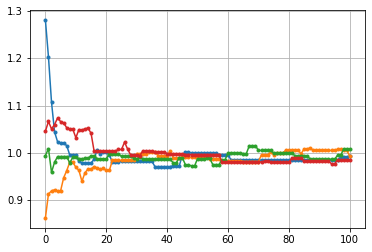

In [13]:
for i in range(4):
    df_HINTS = ok[i]
    df_HINTS['mu'].plot(marker = '.', label = 'HINTS')
plt.grid()


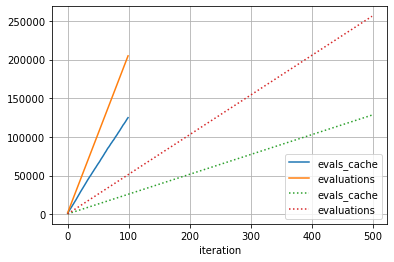

In [24]:
import pandas as pd
df_HINTS[['evals_cache', 'evaluations']].plot()
df_MCMC[['evals_cache', 'evaluations']].plot(linestyle = 'dotted', ax = plt.gca())
plt.xlabel('iteration')
plt.grid()

In [26]:
print(df_HINTS.iloc[-1])
print(df_MCMC.iloc[-1])
# factor is still 5 if we look at evals_cache

nu                                 8
mu                          0.997862
tau                         1.005953
acceptances    [5656, 1120, 234, 55]
rejections       [744, 480, 166, 45]
evals_cache                   124888
evaluations                   204800
Name: 99, dtype: object
nu                    9
mu             0.314003
tau            1.147812
acceptances       [165]
rejections        [335]
evals_cache      128256
evaluations      256000
Name: 499, dtype: object


In [48]:
13118/3072

4.270182291666667

In [ ]:
# does acceptance rate go down for HINTS?

In [12]:
# acceptance statistics at each level in the tree
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

# they will be worse for MCMC than HINTS, because HINTS gives you very directed proposals at the top level

[197973  31870   4892   2087    753]
[58027 32130 11108  1913   247]
[0.77333203 0.49796875 0.30575    0.52175    0.753     ]


In [13]:
# for a publication assume the primitive evaluations are expensive, so your x axis for performance charts should be g.counter

print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 2,560,000; Missed cache: 1,068,225; Miss rate: 41%


In [14]:
import pandas as pd
samples = pd.DataFrame(history)

In [15]:
samples.describe() # looks good!
# HINTS seems tighter than MCMC but need to see whuch is the better _sample_

,nu,mu,tau
count,1000.000000,1000.000000,1000.000000
mean,8.230000,0.990542,1.011263
std,0.448666,0.007765,0.008032
min,7.000000,0.961178,0.986190
25%,8.000000,0.983005,1.006053
50%,8.000000,0.990140,1.008636
75%,8.000000,0.998829,1.017223
max,9.000000,1.008491,1.033910


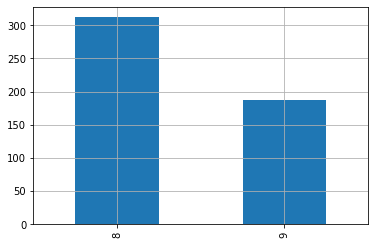

In [16]:
# plot the marginal on nu, throwing away the first half of the data (burn in)
vc = samples['nu'][500:].value_counts().sort_index()
ax = vc.plot(kind='bar')
plt.grid()

# you can get the true distribution for comparison by running a VERY long MCMC chain on the full dataset
# or by exhaustively evaluating (as the parameter space is quite small)